# M4 Monthly Miscellaneous Dataset

This dataset comprises 80 timeseries at monthly frequency, each spanning 324 months, randomly sampled from the M4 forecasting competition. These series provide a consistent length of historical window and are ideal for exploring long-term trends and seasonalities. The M4 dataset contains series drawn from across various sectors.

In [1]:
import pandas as pd
from typing import List, Tuple, Dict, Any
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import os
import sys
import random
import matplotlib.pyplot as plt

In [2]:
dataset_name = "m4_monthly_miscellaneous_ratio_max"

In [3]:
input_fname = "m4_monthly_dataset.tsf"
output_dir = f'./../../processed/{dataset_name}/'
os.makedirs(output_dir, exist_ok=True)
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Read Data

In [4]:
def data_line_generator(filepath: str):
    """
    Generator function that yields each line of data after the '@data' marker in the file.

    Args:
    filepath (str): The path to the file from which to read the data.

    Yields:
    str: The next line of data from the file.
    """
    with open(filepath, 'r', encoding='latin1') as file:
        # Iterate over the file until the '@data' marker is found
        for line in file:
            if line.strip() == "@data":
                break

        # Yield each line of data after the '@data' marker
        for line in file:
            if not line.strip():  # Skip any empty lines that may be present
                continue
            yield line.strip()

# Find lengths of series by series start date

In [5]:

data_gen = data_line_generator(input_fname)

def find_series_lengths_count(max_series=10000):
    '''
    Returns a dictionary of form: 
    {
        (<series_start_date, <series_len>): [list of series_ids of such series...]
    }
    '''
    series_lengths_dict = {}
    for i in range(max_series):
        try:
            line = next(data_gen)
            fields = line.split(":")
            series_name = fields[0]
            series_start_datetime = fields[1]
            series_length = len(fields[-1].split(","))
            id_ = (series_start_datetime, series_length)
            if id_ not in series_lengths_dict:
                series_lengths_dict[id_] = [series_name]
            else: 
                series_lengths_dict[id_].append(series_name)
        except StopIteration: 
            break
        except Exception as e:
            # If any other exception occurs, print the error and the problematic line
            print("An error occurred:", e)
            print("Problematic line:", line)
    return series_lengths_dict

series_lengths_dict = find_series_lengths_count(max_series=200000)

In [6]:
# Confirm Total # of Series
sum([len(s) for s in series_lengths_dict.values()])

48000

In [7]:
# Find count of series per key 
len_counts = {k: len(v) for k, v in series_lengths_dict.items()}
# len_counts

# Find out which series start and length is the most common

In [8]:
max_observed_count_idx = np.argmax(list(len_counts.values()))

max_observed_count_key = list(len_counts.keys())[max_observed_count_idx]
count_of_series = len_counts[max_observed_count_key]

print(
    f"In the M4 daily dataset, there are {count_of_series} series"
    f" which started on `{max_observed_count_key[0]}` and have "
    f"length {max_observed_count_key[1]}. \nThis is the highest count"
    " of series with a specific combination of start date and length."
)
# max_observed_count_key, 

In the M4 daily dataset, there are 6355 series which started on `1990-01-01 12-00-00` and have length 324. 
This is the highest count of series with a specific combination of start date and length.


In [9]:
target_key = max_observed_count_key

# Our candidate series's key
target_key

('1990-01-01 12-00-00', 324)

In [10]:
# There are 1198 such series. We will randomly pick 60 from the list.
# We will limit the length to be 1280 days (~ 3.5 years)

# Process Full Data

In [11]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from typing import List

def generate_timestamps(start_timestamp_str: str, time_steps: int) -> List[str]:
    """
    Generates a list of timestamps starting with the given timestamp and incrementing by 1 month.

    Args:
        start_timestamp_str (str): The starting timestamp in string format 'YYYY-MM-DD HH-MM-SS'.
        time_steps (int): The number of time steps to generate.

    Returns:
        List[str]: A list of dates in string format 'YYYY-MM-DD' incremented monthly.
    """
    # Convert the start timestamp string to a datetime object
    start_timestamp = datetime.strptime(start_timestamp_str, "%Y-%m-%d %H-%M-%S")
    
    # Generate a list of timestamps
    timestamps = [start_timestamp + relativedelta(months=i) for i in range(time_steps)]
    
    # Convert the timestamps back to strings
    timestamp_strs = [timestamp.strftime("%Y-%m-%d") for timestamp in timestamps]
    
    return timestamp_strs

# Test the function with a start timestamp and 5 time steps
month_list = generate_timestamps(target_key[0], target_key[1])
print("month_list first 5: ", month_list[:5])
print("month_list last 5: ", month_list[-5:])
print("month_list length ", len(month_list))


month_list first 5:  ['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01', '1990-05-01']
month_list last 5:  ['2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01']
month_list length  324


In [12]:
data_gen = data_line_generator(input_fname)

def process_data(max_series):
    df_list = []
    timestamp_lookup_dict = {}
    for i in range(max_series):
        try:
            line = next(data_gen)
            fields = line.split(":")
            series_name = fields[0]
            series_start_datetime = fields[1]
            series_vals = fields[-1].split(",")
            num_time_steps = len(series_vals)
            
            # filter for target start year and num of years
            if series_start_datetime != target_key[0] or num_time_steps != target_key[1]:
                continue
                            
            df = pd.DataFrame({'month': month_list })
            df['series'] = series_name
            df['value'] = series_vals
            df['value'] = df['value'].astype(float)
            df_list.append(df)
        except StopIteration: 
            break
        except Exception as e:
            # If any other exception occurs, print the error and the problematic line
            print("An error occurred:", e)
            print("Problematic line:", line)
    all_data = pd.concat(df_list)
    return all_data
        
all_data = process_data(max_series=240000)
print(all_data.head())
print(all_data.shape)

        month series   value
0  1990-01-01   T568  1630.0
1  1990-02-01   T568  1690.0
2  1990-03-01   T568  1740.0
3  1990-04-01   T568  1730.0
4  1990-05-01   T568  1730.0
(2059020, 3)


# Limit data to 80 series

In [13]:
random.seed(0)
sampled_series = random.sample(all_data['series'].unique().tolist(), 80)
# print(sampled_series)

# Filter to the sample
final_data = all_data[all_data['series'].isin(sampled_series)].reset_index(drop=True)
print(final_data.shape)

(25920, 3)


In [14]:
# verify there are 80 series
final_data['series'].nunique()

80

In [15]:
# Verify the observation count is 1280 for all series
final_data[['series']].value_counts().unique()

array([324])

In [16]:
final_data.tail()

,month,series,value
25915,2016-08-01,T38388,3654.0
25916,2016-09-01,T38388,3681.0
25917,2016-10-01,T38388,3736.0
25918,2016-11-01,T38388,3766.0
25919,2016-12-01,T38388,3739.0


In [17]:
series_col = "series"
epoch_col = "month"
time_col = "month"
value_col = 'value'
exog_cols = []

# Visualize

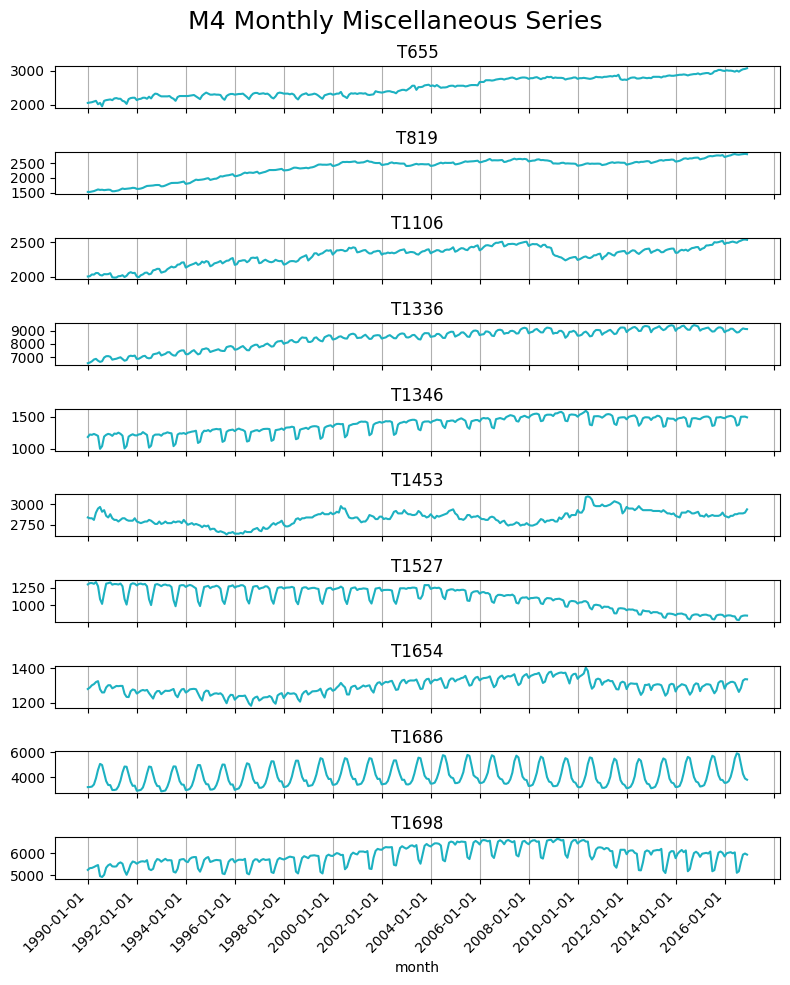

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_trends(df, series_col, val_col, epoch_col, epoch_label, num_series=10,
                filepath=outp_fig_fname, chart_title=dataset_name):
    """
    This function takes a dataframe and a number of series to chart.
    It creates a n x 1 subplot (with n being the number of series, at most 10) and plots those series.
    
    Parameters:
    df (DataFrame): dataframe.
    num_series (int): The number of series to plot, defaulted to 10.
    """
    
    # Get the unique series from the dataframe
    unique_series = df[series_col].unique()
    
    # Limit the number of series to plot
    series_to_plot = unique_series[:min(len(unique_series), num_series)]
    
    # Set up the subplots
    fig, axes = plt.subplots(nrows=min(num_series, len(series_to_plot)), ncols=1, figsize=(8, num_series*1))
    
    # If there's only one series to plot, axes will not be an array, so we wrap it in a list
    if num_series == 1:
        axes = [axes]
    
    # Define the color for the plots
    plot_color = '#1db1c1'
    
    # Plot each series on a separate subplot
    for i, (ax, series_id) in enumerate(zip(axes, series_to_plot)):
        # Filter the dataframe for the current series
        series_data = df[df[series_col] == series_id]
                
        # Plot the data
        ax.plot(series_data[epoch_col], series_data[val_col], color=plot_color)
        
        # Set the title and labels
        ax.set_title(series_id)
        
        # Set x-axis ticks to appear every 5th point
        ax.xaxis.set_major_locator(MultipleLocator(24))
        
        # ax.set_ylabel('Trend')
        # Show x-axis grid
        ax.xaxis.grid(True)
        
        # Show x-axis labels only for the last (bottom) plot
        if i < len(series_to_plot) - 1:
            ax.set_xticklabels([])
        else:
            # Rotate date labels to avoid overlap
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            ax.set_xlabel(epoch_label)            
        
        # Rotate date labels to avoid overlap
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle(chart_title, fontsize=18)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Save figure
    plt.savefig(filepath)
    
    plt.show()

# Plot a few series
plot_trends(
    final_data,
    series_col=series_col,
    val_col=value_col,
    epoch_col=epoch_col,
    epoch_label=epoch_col,
    num_series=10,
    filepath=outp_fig_fname,
    chart_title="M4 Monthly Miscellaneous Series"
)  


# Save Main Data File

In [19]:
all_cols = [series_col, epoch_col, value_col] + exog_cols    
final_data.sort_values(by=[series_col, epoch_col], inplace=True)
final_data[all_cols].to_csv(outp_fname, index=False)